In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Setup paths
results_dir = Path.cwd()
glacier_mass_2000_path = results_dir / "glacier_mass_2000.csv" # initial glacer mass from Zemp et al. (2025())
calendar_years_path = results_dir / "calendar_years"

# Load initial glacier mass data and annual changes
mass_2000 = pd.read_csv(glacier_mass_2000_path, sep=';')

# Build mapping from filename to region data
file_to_mass_data = {}
for _, row in mass_2000.iterrows():
    file_to_mass_data[row['File']] = {
        'region': row['Region'],
        'mass': row['Mass'],
        'error': row['Error']
    }

# Load all annual change files
annual_changes = {}
for csv_file in sorted(glob.glob(str(calendar_years_path / "*.csv"))):
    annual_changes[Path(csv_file).name] = pd.read_csv(csv_file)

In [2]:
# Calculate annual relative change with uncertainty propagation
results = []

for filename, df_changes in sorted(annual_changes.items()):    
    matched_mass_data = file_to_mass_data[filename]
    current_mass = matched_mass_data['mass']
    current_mass_error = matched_mass_data['error']
    
    df_changes_sorted = df_changes.sort_values('start_dates').reset_index(drop=True)
    
    for idx, row in df_changes_sorted.iterrows():
        annual_change = row['combined_gt']
        annual_change_error = row['combined_gt_errors']
        
        relative_change = annual_change / current_mass

        # error propagation
        relative_change_error_term1 = (annual_change_error / annual_change) ** 2
        relative_change_error_term2 = (current_mass_error / current_mass) ** 2
        relative_change_error = abs(relative_change) * np.sqrt(relative_change_error_term1 + relative_change_error_term2)
        
        results.append({
            'region': matched_mass_data['region'],
            'year_start': int(row['start_dates']),
            'year_end': int(row['end_dates']),
            'glacier_mass_at_start': current_mass,
            'glacier_mass_error_at_start': current_mass_error,
            'annual_change_gt': annual_change,
            'annual_change_error': annual_change_error,
            'relative_change': relative_change,
            'relative_change_error': relative_change_error,
            'relative_change_pct': relative_change * 100,
            'relative_change_error_pct': relative_change_error * 100
        })
        
        current_mass = current_mass + annual_change
        current_mass_error = np.sqrt(current_mass_error**2 + annual_change_error**2)

results_df = pd.DataFrame(results)

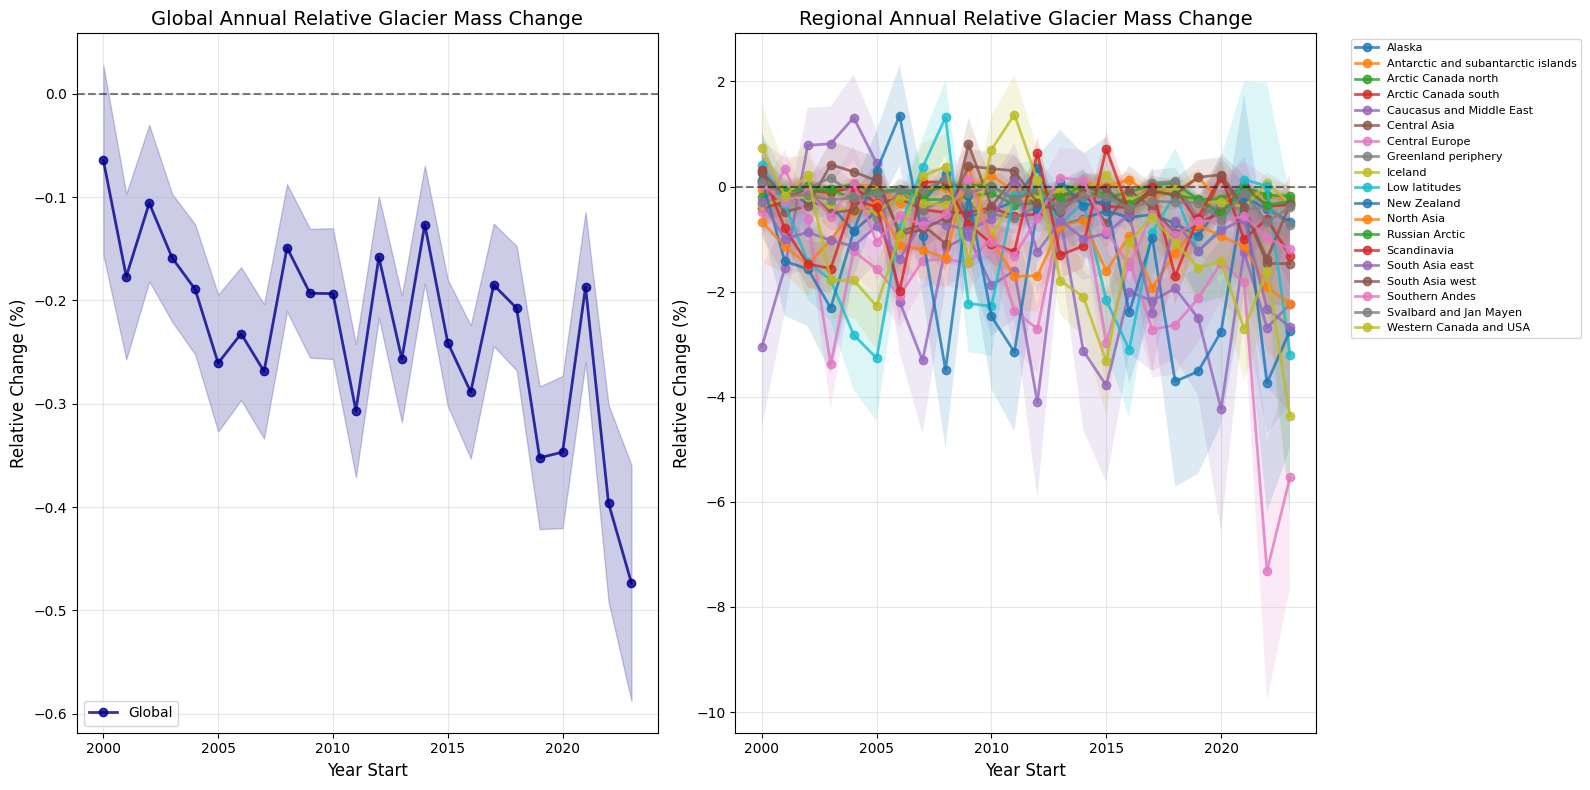

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Separate Global from other regions
all_regions = sorted(results_df['region'].unique())
global_regions = [r for r in all_regions if r.lower() == 'global']
other_regions = [r for r in all_regions if r.lower() != 'global']

# Plot 1: Global - Relative change
ax1 = axes[0]
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    
    ax1.plot(region_data['year_start'], region_data['relative_change_pct'], 
             marker='o', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax1.fill_between(region_data['year_start'],
                      region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                      region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                      alpha=0.2, color='darkblue')

ax1.set_xlabel('Year Start', fontsize=12)
ax1.set_ylabel('Relative Change (%)', fontsize=12)
ax1.set_title('Global Annual Relative Glacier Mass Change', fontsize=14)
ax1.legend(fontsize=10, loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 2: Other regions - Relative change
ax2 = axes[1]

for region in other_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    
    ax2.plot(region_data['year_start'], region_data['relative_change_pct'], 
             marker='o', label=region, alpha=0.8, linewidth=2)
    ax2.fill_between(region_data['year_start'],
                      region_data['relative_change_pct'] - region_data['relative_change_error_pct'],
                      region_data['relative_change_pct'] + region_data['relative_change_error_pct'],
                      alpha=0.15)

ax2.set_xlabel('Year Start', fontsize=12)
ax2.set_ylabel('Relative Change (%)', fontsize=12)
ax2.set_title('Regional Annual Relative Glacier Mass Change', fontsize=14)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(results_dir / 'relative_change_plots.png', dpi=300, bbox_inches='tight')
plt.show()


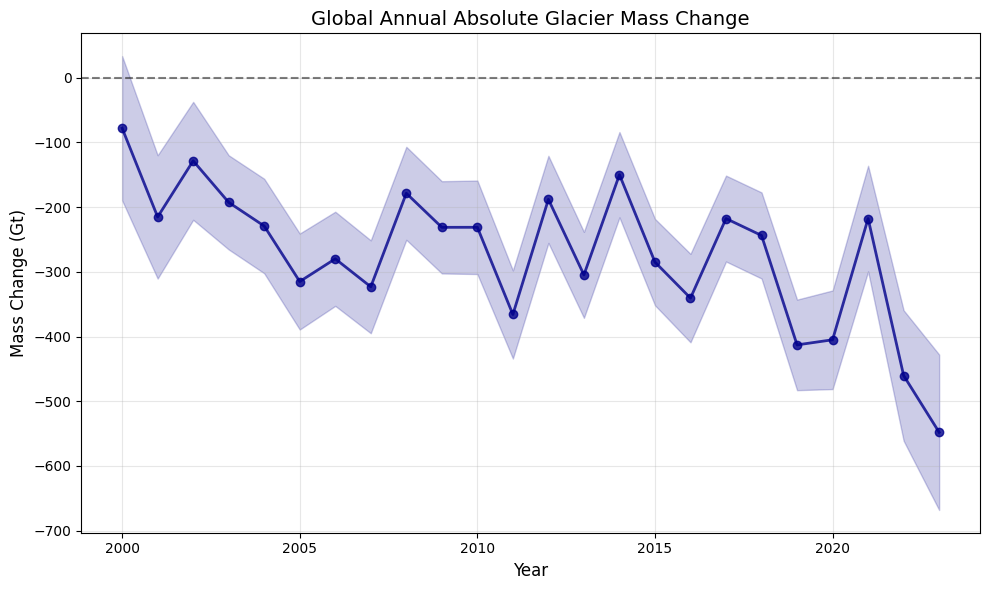

In [11]:
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Separate Global from other regions
all_regions = sorted(results_df['region'].unique())
global_regions = [r for r in all_regions if r.lower() == 'global']

# Plot: Global - Relative change
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')

    ax.plot(region_data['year_start'], region_data['annual_change_gt'],
             marker='o', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(region_data['year_start'],
                    region_data['annual_change_gt'] - region_data['annual_change_error'],
                    region_data['annual_change_gt'] + region_data['annual_change_error'],
                    alpha=0.2, color='darkblue')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Mass Change (Gt)', fontsize=12)
ax.set_title('Global Annual Absolute Glacier Mass Change', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(results_dir / 'global_absolute_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()



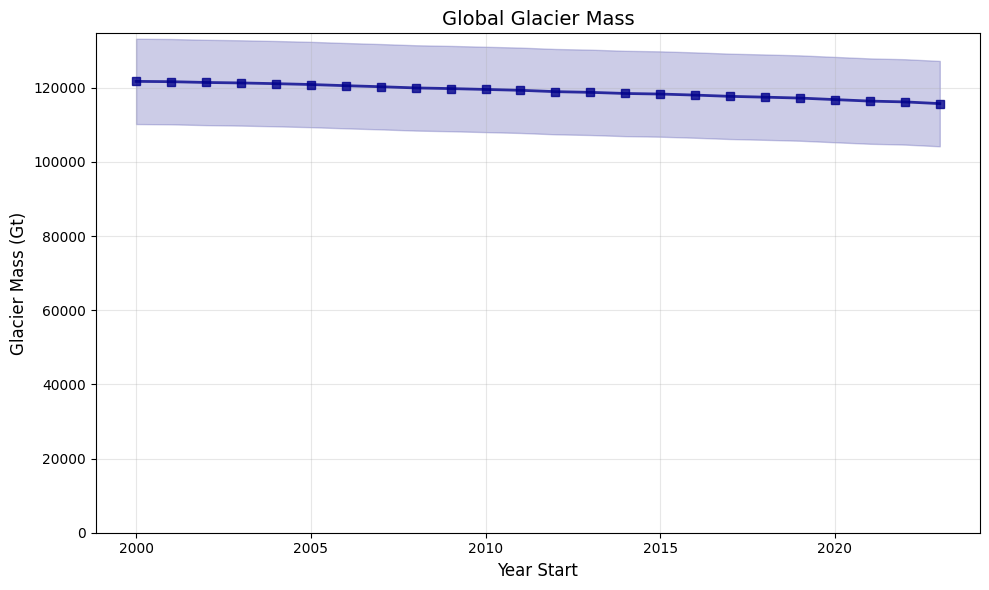

In [12]:
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot: Global - Glacier mass
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax.plot(region_data['year_start'], region_data['glacier_mass_at_start'],
             marker='s', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax.fill_between(region_data['year_start'],
                    region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                    region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                    alpha=0.2, color='darkblue')

ax.set_xlabel('Year Start', fontsize=12)
ax.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax.set_title('Global Glacier Mass', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(results_dir / 'global_glacier_mass_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    x = region_data['year_start'].values
    y = region_data['relative_change_pct'].values
    y_err = region_data['relative_change_error_pct'].values

    if len(x) == 0:
        continue

    # Fit polynomial: quadratic if possible, fallback to linear or constant
    if len(x) >= 3:
        coeffs = np.polyfit(x, y, deg=2)
        poly = np.poly1d(coeffs)
    elif len(x) == 2:
        coeffs = np.polyfit(x, y, deg=1)
        poly = np.poly1d(coeffs)
    else:
        poly = None

    xsmooth = np.linspace(x.min(), x.max(), 200) if poly is not None else x
    ysmooth = poly(xsmooth) if poly is not None else y

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, y, marker='o', linestyle='-', color='tab:blue', alpha=0.6, label='annual')
    ax.plot(
        xsmooth, ysmooth, linestyle='-', color='tab:red', linewidth=2,
        label=('smoothed (quadratic)' if len(x) >= 3 else 'smoothed (linear/const)')
    )
    ax.fill_between(x, y - y_err, y + y_err, color='tab:blue', alpha=0.15)

    # Per-region y-limits (based on this region's data +/- error)
    y_lower_r = np.nanmin(y - y_err)
    y_upper_r = np.nanmax(y + y_err)
    pad_r = 0.05 * (y_upper_r - y_lower_r) if y_upper_r > y_lower_r else 1.0
    ax.set_ylim(y_lower_r - pad_r, y_upper_r + pad_r)

    ax.set_title(f'{region} — Annual Relative Glacier Mass Change (%)')
    ax.set_xlabel('Year Start')
    ax.set_ylabel('Relative Change (%)')
    ax.grid(alpha=0.3)
    ax.legend()

    fname = f"relative_change_{region.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.tight_layout()
    plt.savefig(results_dir / fname, dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# For relative change
# Extract data for global region
global_data = results_df[results_df['region'] == 'Global'].sort_values('year_start')
x = global_data['year_start'].values.astype(float)
y = global_data['relative_change_pct'].values
sigma = global_data['relative_change_error_pct'].values  # Define error column

w = 1.0 / (sigma**2)  # weights

X_lin  = sm.add_constant(x)
X_quad = sm.add_constant(np.column_stack([x, x**2]))

m_lin  = sm.WLS(y, X_lin,  weights=w).fit()
m_quad = sm.WLS(y, X_quad, weights=w).fit()

print("AIC linear:", m_lin.aic)
print("AIC quad  :", m_quad.aic)
print("quad term (t^2) coef, p:", m_quad.params[2], m_quad.pvalues[2])

AIC linear: -57.40933443311606
AIC quad  : -55.87428841218524
quad term (t^2) coef, p: -0.0002478630161640191 0.5284964068114286


In [9]:
# For absolute change
# Extract data for global region
global_data = results_df[results_df['region'] == 'Global'].sort_values('year_start')
x = global_data['year_start'].values.astype(float)
y = global_data['annual_change_gt'].values
sigma = global_data['annual_change_error'].values  # Define the error

w = 1.0 / (sigma**2)  # weights

X_lin  = sm.add_constant(x)
X_quad = sm.add_constant(np.column_stack([x, x**2]))

m_lin  = sm.WLS(y, X_lin,  weights=w).fit()
m_quad = sm.WLS(y, X_quad, weights=w).fit()

print("AIC linear:", m_lin.aic)
print("AIC quad  :", m_quad.aic)
print("quad term (t^2) coef, p:", m_quad.params[2], m_quad.pvalues[2])

AIC linear: 282.6915450904178
AIC quad  : 284.1690521945468
quad term (t^2) coef, p: -0.31595404698654184 0.5040264378578079


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 3: Global - Glacier mass
ax3 = axes[0]
for region in global_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax3.plot(region_data['year_start'], region_data['glacier_mass_at_start'], 
             marker='s', label=region, alpha=0.8, linewidth=2, color='darkblue')
    ax3.fill_between(region_data['year_start'],
                      region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                      region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                      alpha=0.2, color='darkblue')
ax3.set_xlabel('Year Start', fontsize=12)
ax3.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax3.set_title('Global Glacier Mass', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=0)

# Plot 4: Other regions - Glacier mass
ax4 = axes[1]
for region in other_regions:
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    ax4.plot(region_data['year_start'], region_data['glacier_mass_at_start'], 
             marker='s', label=region, alpha=0.8, linewidth=2)
    ax4.fill_between(region_data['year_start'],
                      region_data['glacier_mass_at_start'] - region_data['glacier_mass_error_at_start'],
                      region_data['glacier_mass_at_start'] + region_data['glacier_mass_error_at_start'],
                      alpha=0.15)
ax4.set_xlabel('Year Start', fontsize=12)
ax4.set_ylabel('Glacier Mass (Gt)', fontsize=12)
ax4.set_title('Regional Glacier Mass', fontsize=14)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(bottom=-1000)

plt.tight_layout()
plt.savefig(results_dir / 'glacier_mass_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Test for significant trends in relative change
trend_results = []

for region in sorted(results_df['region'].unique()):
    region_data = results_df[results_df['region'] == region].sort_values('year_start')
    
    x = region_data['year_start'].values
    y = region_data['relative_change_pct'].values
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Calculate trend in % per year
    trend_per_year_pct = slope
    
    # Determine significance (using p < 0.05 as threshold)
    is_significant = p_value < 0.05
    trend_direction = 'increasing' if slope > 0 else 'decreasing'
    
    trend_results.append({
        'region': region,
        'slope_pct_per_year': round(trend_per_year_pct, 4),
        'intercept': round(intercept, 2), 
        'r_squared': round(r_value**2, 4),
        'p_value': round(p_value, 4), 
        'std_err': round(std_err, 4),
        'is_significant': is_significant,
        'trend_direction': trend_direction
    })

trend_df = pd.DataFrame(trend_results)

print(trend_df)

In [ ]:
# Export results to CSV
# output_csv = results_dir / 'annual_relative_change_results.csv'
# results_df.to_csv(output_csv, index=False)
# print(f"Results exported to: {output_csv}")